In [3]:
# importing necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, f1_score, plot_confusion_matrix, accuracy_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('my_dataframe.csv')
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df['Weeks.on.chart'] = df['Weeks.on.chart'].fillna(0)

In [6]:
df['Peak.position'] = df['Weeks.on.chart'].fillna(df['Weekly.rank'])

# EDA

### Audio Features

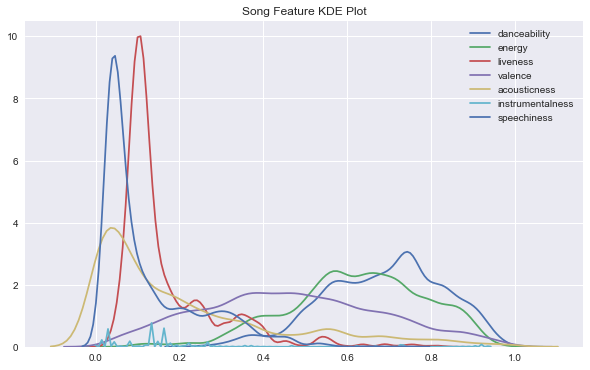

In [7]:
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(df['danceability'])
sns.kdeplot(df['energy'])
sns.kdeplot(df['liveness'])
sns.kdeplot(df['valence'])
sns.kdeplot(df['acousticness'])
sns.kdeplot(df['instrumentalness'])
sns.kdeplot(df['speechiness'])
plt.title('Song Feature KDE Plot')
plt.show()

In [ ]:
# comparing danceability between top 25 songs and top 100
top_ten = df[df['Weekly.rank']<=10]


fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['danceability'], label = 'top 10')
sns.kdeplot(df['danceability'], label = 'top 100')
plt.title('Danceability for Top 10 vs Top 100')
plt.show()

In [ ]:
# comparing liveness of songs in the top 25 vs top 100 
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['liveness'], label = 'top 10')
sns.kdeplot(df['liveness'], label = 'top 100')
plt.title('Liveness for Top 10 vs Top 100')
plt.show()

plt.savefig('liveness.png')

In [ ]:
# comparing liveness of songs in the top 25 vs top 100 
fig, ax = plt.subplots(figsize=[10,6])
sns.kdeplot(top_ten['loudness'], label = 'top 10')
sns.kdeplot(df['loudness'], label = 'top 100')
plt.title('Loudness for Top 10 vs Top 100')
plt.show()

plt.savefig('loudness.png')

In [ ]:
audio_df = df[['Weekly.rank','danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

In [ ]:
audio_df.corr()

### Genres

In [ ]:
genres = []
for row in df['Genre']: 
    genres.extend(row.split('|'))
genre_dict = {}
for genre in genres:
    if genre in genre_dict: 
        genre_dict[genre] += 1
    else:
        genre_dict[genre] = 1
# creating df 
genres = {'Genre': list(genre_dict.keys()), 'Count': list(genre_dict.values())}
genre_df = pd.DataFrame(genres)
sorted_genres = genre_df.sort_values(by='Count',ascending=False)

In [ ]:
sorted_genres

In [ ]:
sorted_genres

In [ ]:
genre_df = sorted_genres[sorted_genres['Count']>=50]
genre_df

In [ ]:
# barplot of genres
x = genre_df['Genre']
y = genre_df['Count']

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x,y)
sns.barplot(x,y)

ax.set_xticklabels(x,rotation=80)
ax.set_ylabel("Count")
ax.set_title("Frequency of Genres");

# Modeling

## Preprocessing

In [8]:
# creating 'Top_10' column 
df['Top_10']= np.where(df['Weekly.rank']<=10,1,0)

In [18]:
# df with the features I want to use for modeling
df_modeling = df[['Weeks.on.chart','Peak.position','danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms','Top_10']]

selected_features = ['Weeks.on.chart','Peak.position','danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature','Top_10']

In [11]:
# scaling my continuous variables
ss = StandardScaler()
df_features_scalled = pd.DataFrame(ss.fit_transform(df_modeling[selected_features]), columns=[selected_features])
df_features_scalled.describe()

,Weeks.on.chart,Peak.position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Top_10
count,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03,7.715000e+03
mean,9.240394e-16,9.240394e-16,-2.870319e-16,-2.921549e-16,2.131801e-16,3.288217e-16,-4.475141e-16,2.864706e-16,1.039969e-15,-3.284728e-16,-8.844369e-17,-8.093188e-17,-2.196972e-16,-2.968533e-16,2.188863e-15,4.420745e-17
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-1.117796e+00,-1.117796e+00,-3.200945e+00,-3.531809e+00,-1.530429e+00,-8.515819e+00,-1.390489e+00,-8.743042e-01,-9.408377e-01,-1.002338e-01,-1.189333e+00,-2.038407e+00,-2.270406e+00,-4.199011e+00,-1.236765e+01,-3.375182e-01
25%,-7.405850e-01,-7.405850e-01,-7.354008e-01,-6.235060e-01,-9.712803e-01,-4.875239e-01,-1.390489e+00,-7.187982e-01,-7.633786e-01,-1.002338e-01,-6.145310e-01,-7.082591e-01,-8.742985e-01,-5.519470e-01,8.338348e-02,-3.375182e-01
50%,-2.690714e-01,-2.690714e-01,1.078868e-01,5.399986e-02,1.470165e-01,1.366095e-01,7.191714e-01,-4.799549e-01,-3.763162e-01,-1.002338e-01,-4.139404e-01,-4.766777e-02,-5.291159e-02,-9.719617e-02,8.338348e-02,-3.375182e-01
75%,4.853504e-01,4.853504e-01,7.439257e-01,6.879962e-01,7.061649e-01,6.022532e-01,7.191714e-01,4.814327e-01,4.379712e-01,-1.001595e-01,2.518856e-01,7.120122e-01,7.488476e-01,4.282256e-01,8.338348e-02,-3.375182e-01
max,4.446065e+00,4.446065e+00,1.973125e+00,2.229477e+00,1.544888e+00,1.984660e+00,7.191714e-01,5.292666e+00,3.450173e+00,2.274803e+01,5.721772e+00,2.391802e+00,3.325259e+00,1.022772e+01,4.233729e+00,2.962803e+00


In [12]:
# creating features and target variables
X = df_modeling.drop(columns=['Top_10'])
y = df_modeling['Top_10']

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

## Dummy Classifier

In [14]:
dummy_clf = DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(X_train, y_train)
dummy_train_pred = dummy_clf.predict(X_train)
dummy_pred = dummy_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, dummy_train_pred))
print('Testing Accuracy: ',accuracy_score(y_test, dummy_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, dummy_train_pred))
print('Testing F1-Score: ', f1_score(y_test, dummy_pred))
print('\n\n')
print('Training Recall: ', recall_score(y_train, dummy_train_pred))
print('Testing Recall: ',recall_score(y_test, dummy_pred))

Training Accuracy:  0.8988982501620221
Testing Accuracy:  0.8930654569021387



Training F1-Score:  0.0
Testing F1-Score:  0.0



Training Recall:  0.0
Testing Recall:  0.0


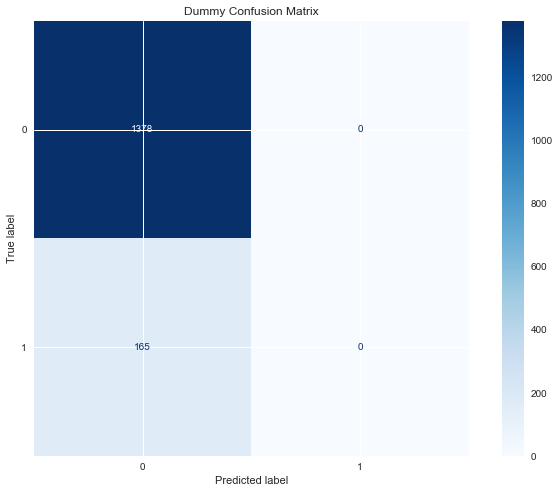

In [16]:
# plot confusion matrix
fig,ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(dummy_clf, X_test, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('Dummy Confusion Matrix')
fig.savefig('Dummy_Confusion_Matrix');

As we can see in the above confusion matrix, everything was classified as not being in the top 100. This is due to the fact that we have a class imbalance. 

## Logistic Regression

In [19]:
df_modeling.columns

Index(['Weeks.on.chart', 'Peak.position', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'Top_10'],
      dtype='object')

In [21]:
df_modeling = pd.get_dummies(df_modeling)

In [22]:
df_modeling.corr()

,Weeks.on.chart,Peak.position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Top_10
Weeks.on.chart,1.000000,1.000000,0.006058,-0.015059,0.060865,0.045220,0.016352,-0.091677,0.014443,-0.044220,-0.070578,-0.013028,-0.067196,0.030393,0.061107
Peak.position,1.000000,1.000000,0.006058,-0.015059,0.060865,0.045220,0.016352,-0.091677,0.014443,-0.044220,-0.070578,-0.013028,-0.067196,0.030393,0.061107
danceability,0.006058,0.006058,1.000000,-0.054431,-0.045347,-0.013078,-0.159292,0.354922,-0.235260,-0.032057,0.032858,0.180359,-0.022351,-0.174365,0.145199
energy,-0.015059,-0.015059,-0.054431,1.000000,0.038048,0.719461,-0.024074,-0.049442,-0.517496,-0.096729,0.078162,0.389917,0.124526,0.002750,-0.052682
key,0.060865,0.060865,-0.045347,0.038048,1.000000,-0.026506,-0.122396,0.033413,-0.002165,-0.010423,-0.134258,0.038316,-0.111613,-0.028497,-0.014004
loudness,0.045220,0.045220,-0.013078,0.719461,-0.026506,1.000000,-0.036716,-0.163389,-0.398422,-0.240373,-0.002618,0.266795,0.107930,-0.011831,-0.011182
mode,0.016352,0.016352,-0.159292,-0.024074,-0.122396,-0.036716,1.000000,-0.204676,0.073585,0.007393,-0.056804,0.036560,0.043151,0.093005,0.041483
speechiness,-0.091677,-0.091677,0.354922,-0.049442,0.033413,-0.163389,-0.204676,1.000000,-0.143136,0.000912,0.067027,-0.033853,0.147742,-0.133180,0.016371
acousticness,0.014443,0.014443,-0.235260,-0.517496,-0.002165,-0.398422,0.073585,-0.143136,1.000000,0.097711,-0.155233,-0.117559,-0.130618,-0.032836,-0.004955
instrumentalness,-0.044220,-0.044220,-0.032057,-0.096729,-0.010423,-0.240373,0.007393,0.000912,0.097711,1.000000,-0.005873,-0.045162,0.032308,-0.048835,-0.008050


In [23]:
target = df_modeling['Top_10']
df_features = df_modeling.drop(['Top_10'], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=25,test_size=0.30)

In [25]:
log = LogisticRegression()
log.fit(X_train, y_train)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)
log_acc = metrics.accuracy_score(y_test, log_preds)

print(classification_report(y_test, log_preds, target_names=['Top 100','Top 10']))

              precision    recall  f1-score   support

     Top 100       0.90      1.00      0.95      2088
      Top 10       0.00      0.00      0.00       227

    accuracy                           0.90      2315
   macro avg       0.45      0.50      0.47      2315
weighted avg       0.81      0.90      0.86      2315



This is also showing us that we have class imbalance because it is very skewed towards our top 100 class. 

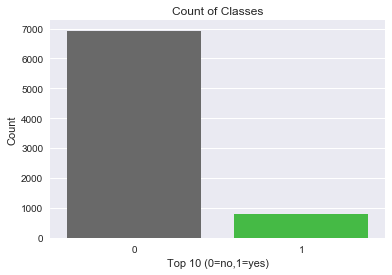

In [27]:
# visualizing this class imbalance

# Create an array with the colors you want to use
colors = ["dimgrey", "limegreen"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

fig = sns.countplot(x='Top_10', data=df_modeling, palette=customPalette)

fig.set_title('Count of Classes')
fig.set(xlabel='Top 10 (0=no,1=yes)',ylabel='Count')
plt.show();

##### Dealing with class imbalance

In [28]:
# smote
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
# Preview synthetic sample class distribution
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Synthetic sample class distribution: 

1    4838
0    4838
Name: Top_10, dtype: int64


In [30]:
log = LogisticRegression()
log.fit(X_train_resampled, y_train_resampled)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)
log_acc = metrics.accuracy_score(y_test, log_preds)

print(classification_report(y_test, log_preds, target_names=['Top 100','Top 10']))

              precision    recall  f1-score   support

     Top 100       0.00      0.00      0.00      2088
      Top 10       0.10      1.00      0.18       227

    accuracy                           0.10      2315
   macro avg       0.05      0.50      0.09      2315
weighted avg       0.01      0.10      0.02      2315



In [31]:
# confusion matrix ??


In [32]:
# class weight balanced
lr_clf_weighted = LogisticRegression(solver='liblinear', class_weight = 'balanced')
lr_clf_weighted.fit(X_train, y_train)
y_weighted_train = lr_clf_weighted.predict(X_train)
y_weighted_test = lr_clf_weighted.predict(X_test)

f1_train = metrics.f1_score(y_train, y_weighted_train)
f1_test = metrics.f1_score(y_test, y_weighted_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_weighted_test))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Test Accuracy score:  0.6349892008639308
Train F1 score:  0.2861303239898071
Test F1 score:  0.26712922810060713


In [33]:
coef_names = list(zip(df_features.columns, lr_clf_weighted.coef_[0]))
coef_names

[('Weeks.on.chart', 0.011744666919301993),
 ('Peak.position', 0.011744666919301993),
 ('danceability', 4.080296311007224),
 ('energy', -1.1535904405175228),
 ('key', -0.004351931946018292),
 ('loudness', 0.05658125682770385),
 ('mode', 0.48192354429501216),
 ('speechiness', 0.6236406538057778),
 ('acousticness', 0.24960902750887748),
 ('instrumentalness', 0.31359367656782544),
 ('liveness', 0.26340693153184724),
 ('valence', 0.25476092367526704),
 ('tempo', -0.008699063266875147),
 ('duration_ms', 2.7617318521346385e-06)]

In [34]:
# Logistic regression with grid search
logreg = LogisticRegression()
parameters = {'C': [0.75,1.0,1.25,1.5],
             'max_iter': [100,200,300,400,500],
             'penalty': ['l1', 'l2']}
grid_tree1 = GridSearchCV(logreg, parameters, cv=5, scoring='f1',verbose =1,n_jobs=-1)

grid_tree1.fit(X_train_resampled,y_train_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.75, 1.0, 1.25, 1.5],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [35]:
#Predict the response for test dataset
y_pred = grid_tree1.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred, target_names=['Top 100','Top 10']))

              precision    recall  f1-score   support

     Top 100       0.00      0.00      0.00      2088
      Top 10       0.10      1.00      0.18       227

    accuracy                           0.10      2315
   macro avg       0.05      0.50      0.09      2315
weighted avg       0.01      0.10      0.02      2315



In [ ]:
# confusion matrix ??


## Random Forest 

In [36]:
rfc = RandomForestClassifier(random_state = 25, n_estimators=20, max_features=6)
rfc.fit(X_train_resampled, y_train_resampled)
rfc_preds = rfc.predict(X_test)

rfc_f1 = metrics.f1_score(y_test, rfc_preds)
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# checking accuracy on the test data
print(classification_report(y_test, rfc_preds, target_names=['Top 100','Top 10']))

              precision    recall  f1-score   support

     Top 100       0.98      0.97      0.98      2088
      Top 10       0.76      0.81      0.78       227

    accuracy                           0.96      2315
   macro avg       0.87      0.89      0.88      2315
weighted avg       0.96      0.96      0.96      2315



Confusion matrix, without normalization
[[2030   58]
 [  43  184]]


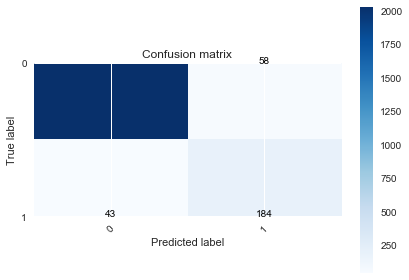

In [46]:
cnf_matrix = confusion_matrix(y_test, rfc_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

In [37]:
# Random Forest with GridSearch
param_grid2 = { 
    'n_estimators': [50,100,150,200],
    'max_features': [4,5,6,7,8],
    'criterion' : ['gini','entropy']
    
}

rfc_CV = RandomForestClassifier(random_state = 25)
rfc_CV = GridSearchCV(estimator=rfc_CV, param_grid=param_grid2, cv= 10, scoring='f1', verbose=1, n_jobs=-1)
rfc_CV.fit(X_train_resampled, y_train_resampled)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.2min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=25),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=1)

In [38]:

# Identify the best params 
print(rfc_CV.best_params_)
print(rfc_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rfc_CV.best_score_)

#predict on the test set
test_preds_rfc_CV = rfc_CV.best_estimator_.predict(X_test)

# checking metrics
print(classification_report(y_test, test_preds_rfc_CV, target_names=['Top 100','Top 10']))

{'criterion': 'entropy', 'max_features': 4, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', max_features=4, random_state=25)
0.9713871104626369
              precision    recall  f1-score   support

     Top 100       0.98      0.97      0.98      2088
      Top 10       0.77      0.82      0.80       227

    accuracy                           0.96      2315
   macro avg       0.88      0.90      0.89      2315
weighted avg       0.96      0.96      0.96      2315

